# PCA Lab

In this lab we will be practicing using PCA to analyze a genomic dataset. 

For all the following steps, you can write code into a bash file and run using sbatch or you can start an interactive job on the hpcc and run line by line. See [here](https://docs.icer.msu.edu/Interactive_Job/) for info about interactive jobs. What worked for me was asking for 2 nodes, 4 cores, and 1GB of memory per cpu.


## The data

*Arabidopsis thaliana*. This data was downloaded from [The 1001 Genomes Project](https://1001genomes.org/data/GMI-MPI/releases/v3.1) and the file is called `1001genomes_snp-short-indel_only_ACGTN.vcf.gz` and is in the '/mnt/research/PLB812_FS24_S001/12_PCA' folder.

## Running PCA 

We will be using the software Plink to run PCA. Our first step will be loading the Plink module on the hpcc.

`$module purge` <br>
`$module load PLINK/2.00a3.7-gfbf-2023a`

Next, if your data is in a vcf file, you need to convert it to a plink format.  We will also want to filter these files to give us SNPs that are not in linkage disequilibrium with each other, and to remove rare sites or sites with a lot of missing data. You can look up each of the options in the following command to see how they work.

`$plink2 --vcf 1001genomes_snp-short-indel_only_ACGTN.vcf.gz --set-all-var-ids @:# --indep-pairwise 100 5 0.2 --geno 0.05 --max-alleles 2 --maf 0.05 --allow-extra-chr --make-bed --out arabidopsis`

If you were to do this another time and your data wass already in a plink format (file names end with **.bed** and **.bim** and **.fam** and have the same file prefix), you could run the following command:

`$plink2 -bfile [file-prefix] --indep-pairwise 100 20 0.2 --geno 0.05 --max-alleles 2 --maf 0.05 --allow-extra-chr --make-bed --out [file-prefix].filtered`

Once you have filtered your plink files of SNPs, it is time to run the PCA analysis! The command is below. If you used the command above to conver the Arabidopsis vcf to pca format, replace [file-prefix] with arabidopsis.

`$plink2 -bfile [file-prefix] --extract [file-prefix].prune.in --pca --allow-extra-chr --out [file-prefix]-pca`

Note the `--extract` flag here directs you towards a list of sites that was generated in the previous filtered set. If you were to skip this, plink would try to run the PCA on all the sites, not just the sites that passed the filters. 

You can use **less** to look at the output files from this step, which will be `[file-prefix]-pca.eigenvec` and `[file-prefix]-pca.eigenval`.

## Making plots
You will need some extra information about the genotypes in your PCA.

This file is called `accessions.csv`.

There is a file called 'pca-plots.Rmd' in the class folder ('/mnt/research/PLB812_FS24_S001/12_PCA') that has code for making PCA plots. Please open it up in Rstudio using ondemand, edit the paths for your own data, and make PCA plots for all the SNPs and then for PCAs made from each subset.

When you're done, put the PCA plots in this notebook.

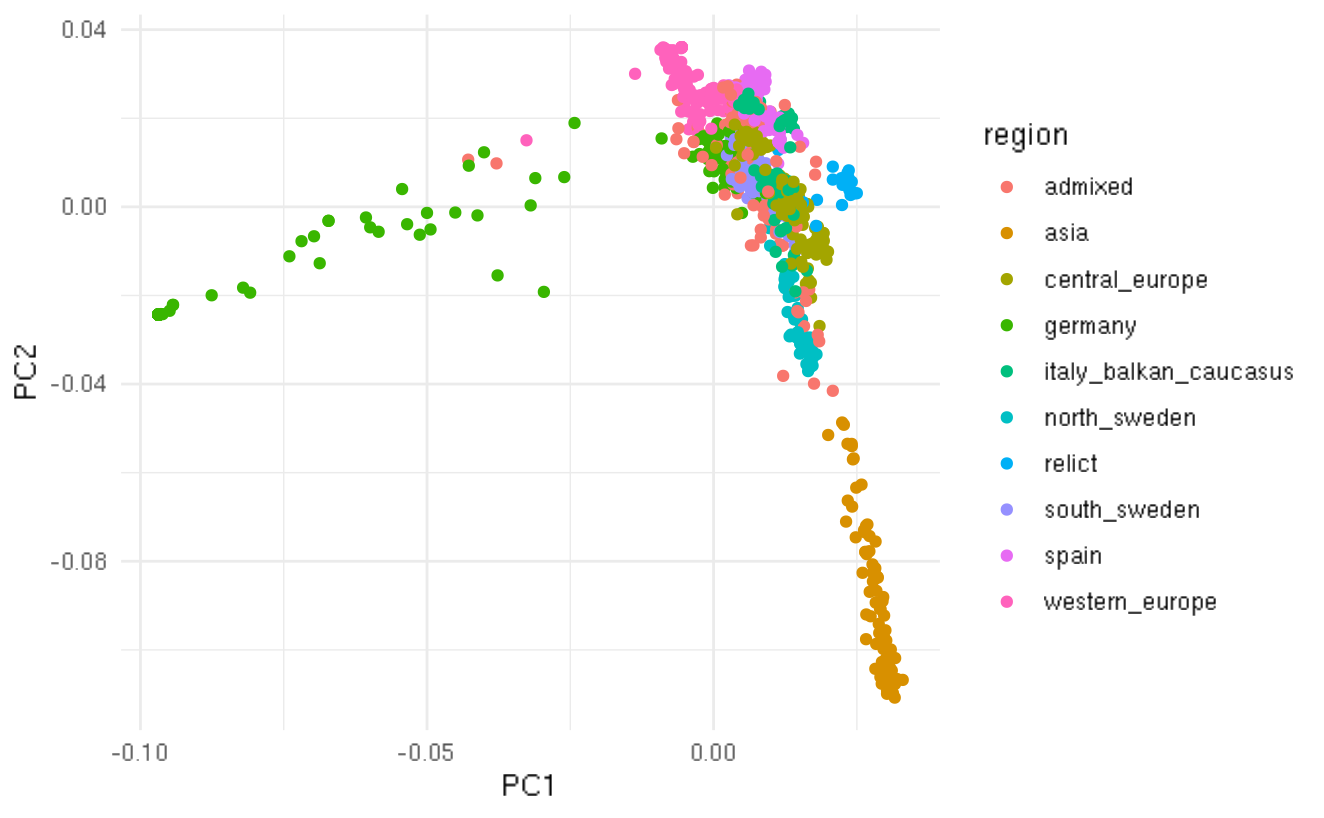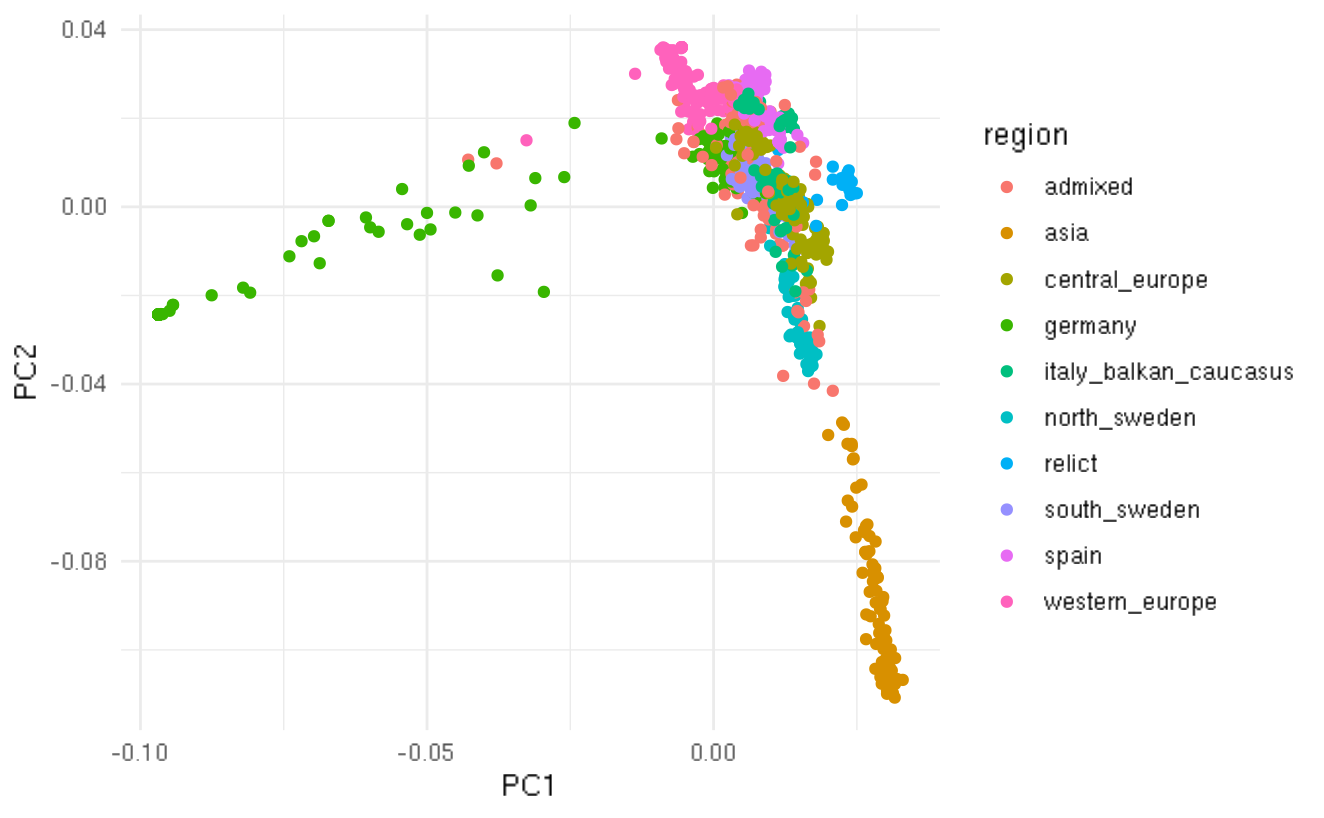


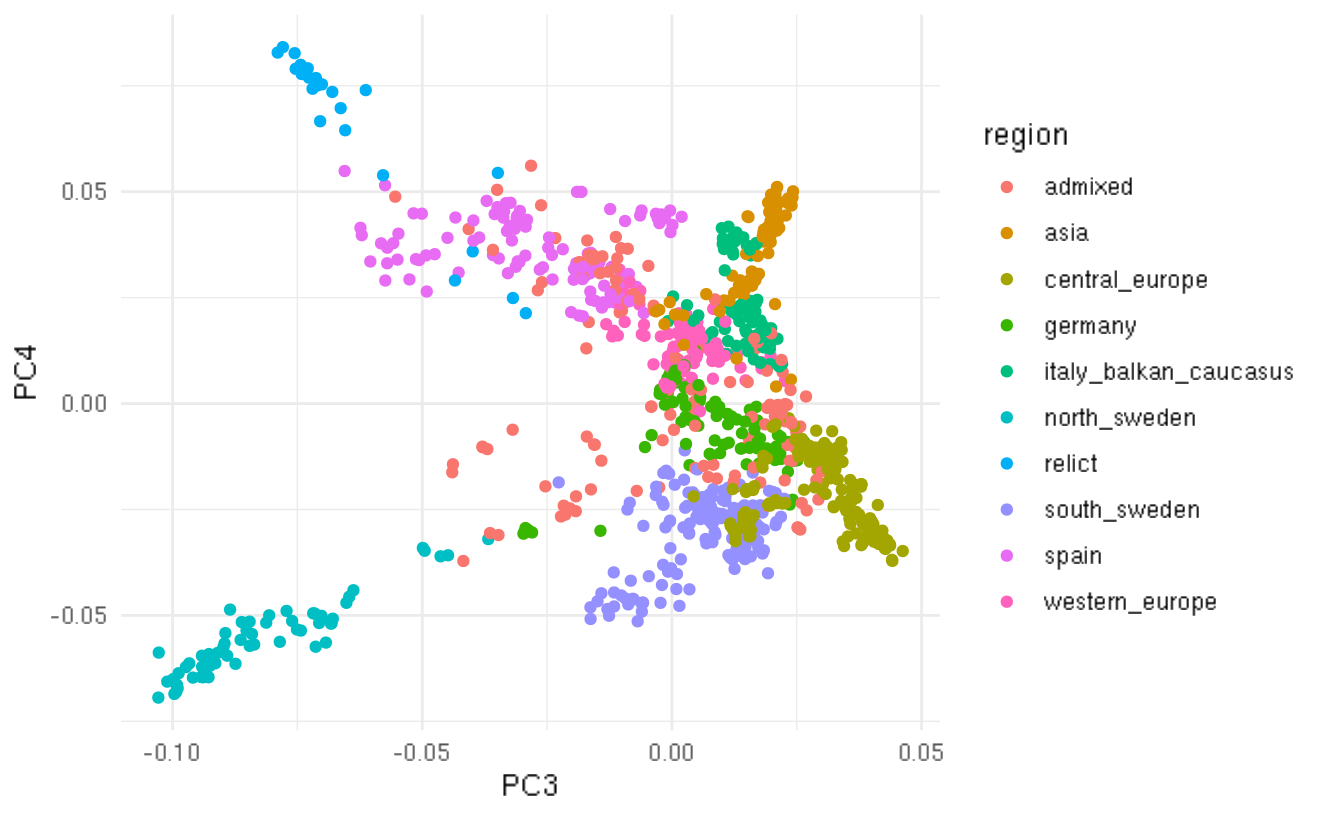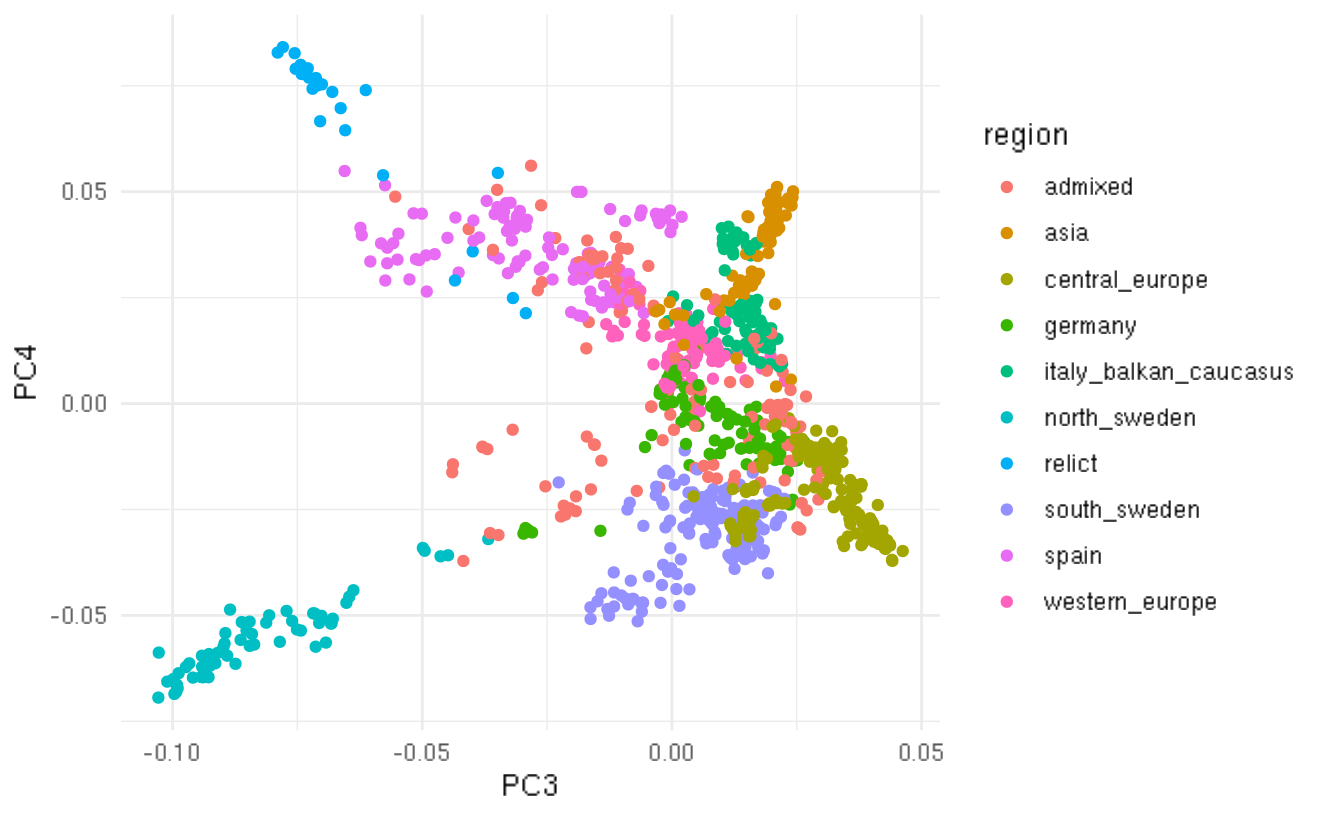

## Lab option 1: Subsampling SNPs

We talked in class about how the number of SNPs is important for making a PCA. In the lab we'll investigate this using the *A. thaliana* data.

We can efficiently subsample a smaller dataset by sampling from the [file-prefix].filtered.in site, and then only using these sites when we run the PCA. To subsample 100 sites, use the following bash command:

`shuf [file-prefix].filtered.in | head -n 100 > [file-prefix].100.in`

Take a second to look at this command and think about what the different parts of it do (or ask a neighbor or Emily!).

Modify the command to take subsamples of 100, 1000, and 10,000 sites.

You can count the number of lines in your `[file-prefix].x.in` files using `wc -l [file]`. Use this to check that your subsampling worked correctly. Then, rerun your PCA on these subsamples.

100 - 
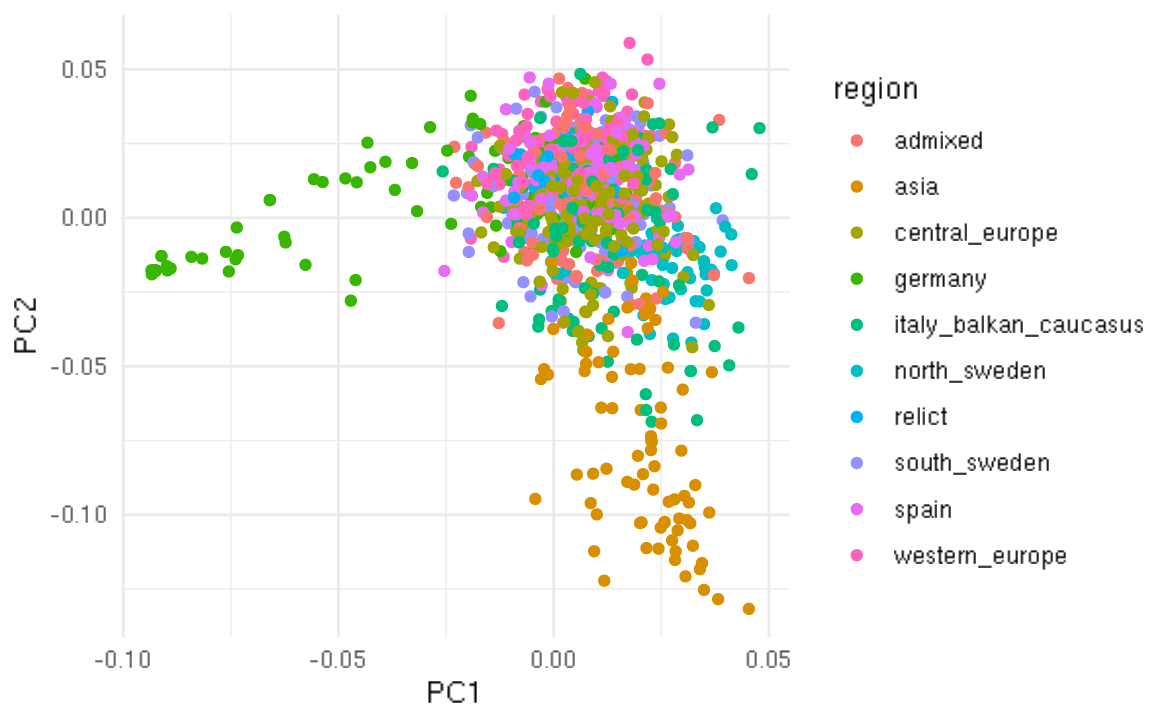
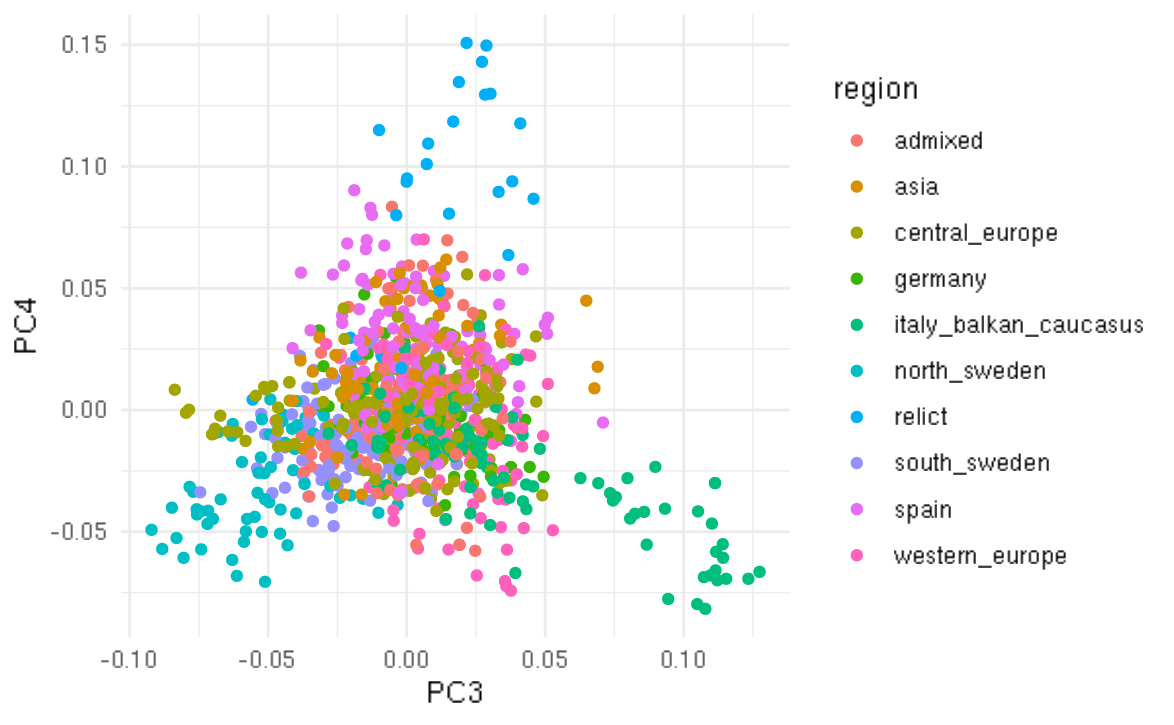

1000 -
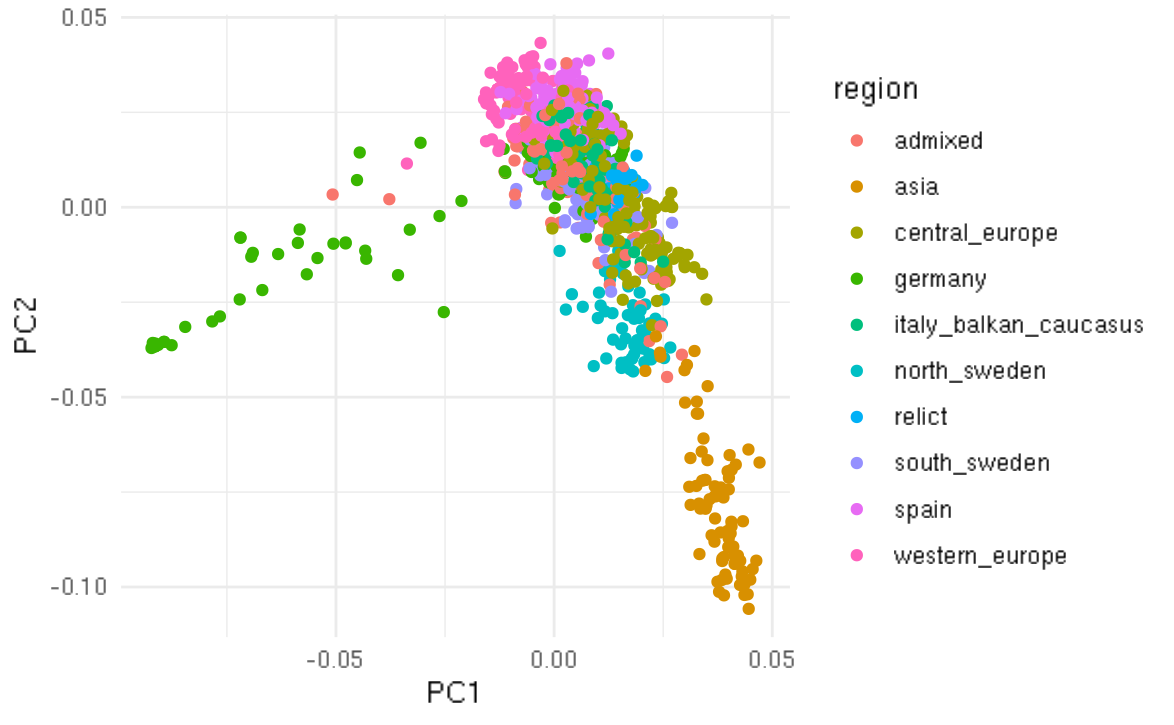
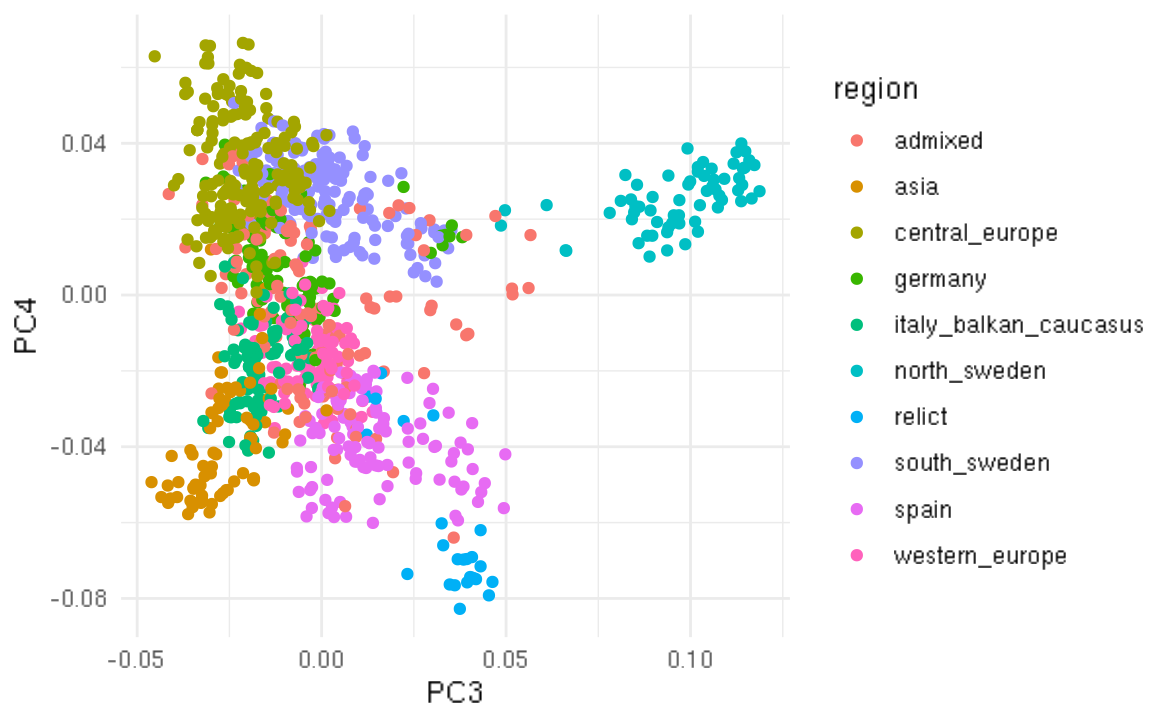

10000 - 
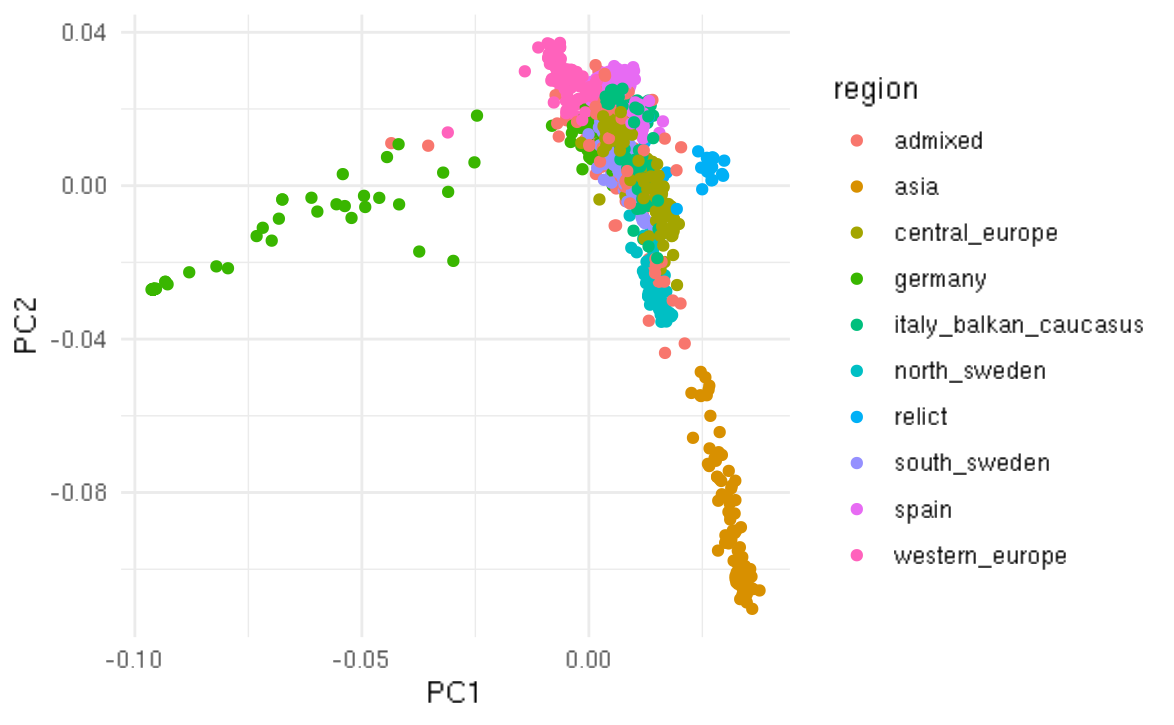
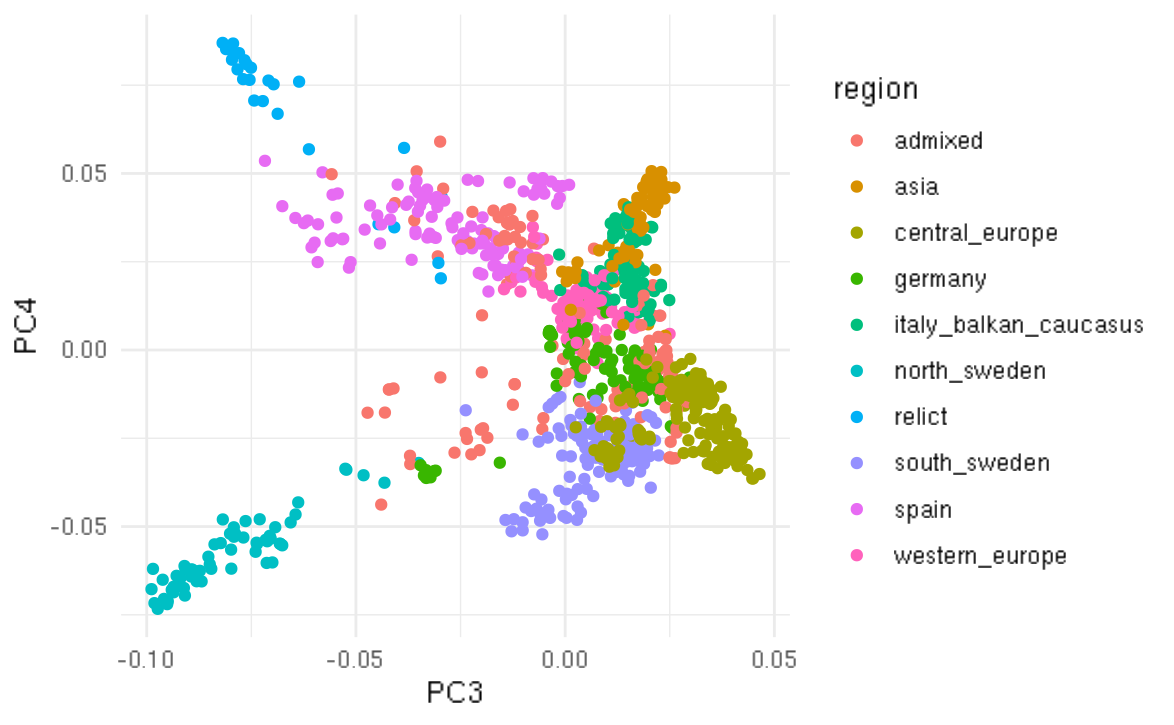

### Questions

1. Based on the plot you've made, what are the major axes of variation in your diversity dataset? How do you know this?
  - The major axes of variation in my diversity set is PC 1 and 2 because they capture the highest genomic differences. You can tell thsi because at 100 SNPs the PC1/PC2 anaylsis was a cluster and as the number of SNPs increased, the cluster spread out into an upside down L distribution.
   
3. How many sites were in the dataset of all SNPs that you used to calculate the PCA without subsampling? How did you find this out?
  - There are 41060 in the arabidopsis.prune.in that was used to calculate PCA. I used the wc to count and -ls to tell it to only count the lines (wc -l arabidopsis.prune.in). I used the prune.in file because this was our output file after pruning/filtering.

4. How did changing the number of SNPs affect the PCA plots you made? How many SNPs would you recommend that another researcher use for Arabidopsis PCA?
  - As the number of SNPs increased, you can see major clusters form and 10000 SNPs are a better representation of where the different regions are accurately clustering. I would recommend another researcher use no less than 1000 SNPs, if they were in the 5,0000 to 10,000 range that would be better and show more genetic diversity and variation. 

## Lab Option 2: Other species

You may be interested in testing out PCA on some other species. James Whiting, Sam Yeaman and colleagues assembled a great repository of vcfs for a variety of plant species [here](https://datadryad.org/dataset/doi:10.5061/dryad.15dv41p57#readme). 

For this option, pick a species and transfer the vcf file to the hpcc. Then use the steps from above to convert the vcf to plink format and calculate the pcs. Use the R script to make a figure. Check the repository to see if there's extra information you can add to your figure. When you're done, add the figure to this notebook.

### Questions
1. Based on the plot that you've made, what are the major axes of variation in your diversity dataset? How do you know this?
2. 

## Other helpful stuff:

[The Documentation for Plink2](https://www.cog-genomics.org/plink/2.0/)

[A tutorial on PCA using Plink](https://www.zoology.ubc.ca/~schluter/R/Genomics.html#PCA_with_PLINK2)

In [2]:
#Code for PCA
---
title: "pca-plots"
output: html_document
date: "2024-08-14"
---

```{r setup, include=FALSE}
knitr::opts_chunk$set(echo = TRUE)
library(dplyr)
library(ggplot2)
```


Code to make a single PCA plot is below. Please save your own version of this file and edit to make PCA plots for all the different PCA analyses generated in the original assignment.
```{r}
## read in PC data
## CHANGE THESE PATHS TO YOUR OWN DATA
mypcs <- read.table('/mnt/research/PLB_812_F25_001/Users/goweraud/arabidopsis-pca.eigenvec')

##make some sensible names
names(mypcs)[1:12] <- c('code','ID','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10')

## read in data about arabidopsis
mydat <- read.table('/mnt/research/PLB_812_F25_001/Users/goweraud/accessions.csv', header=F, sep=",")
#make some sensible names again
names(mydat)[1] <- "ID"
names(mydat)[11] <- "region"

## join files together
myall <- dplyr::left_join(mypcs, mydat, by="ID")

## make a PC plot with PCs 1 and 2
ggplot(myall, aes(x=PC1, y=PC2, color=region))+
  geom_point()+
  theme_minimal()

##make a PC plot with PCs 3 and 4
ggplot(myall, aes(x=PC3, y=PC4, color=region))+
  geom_point()+
  theme_minimal()
```

SyntaxError: invalid syntax (1702125023.py, line 2)